In [2]:
!pip install qiskit
!pip install qiskit-aer
!pip install matplotlib numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 122.3 MB/s eta 0:00:00


--- Running simulation for 5 layers ---
--- Running simulation for 10 layers ---


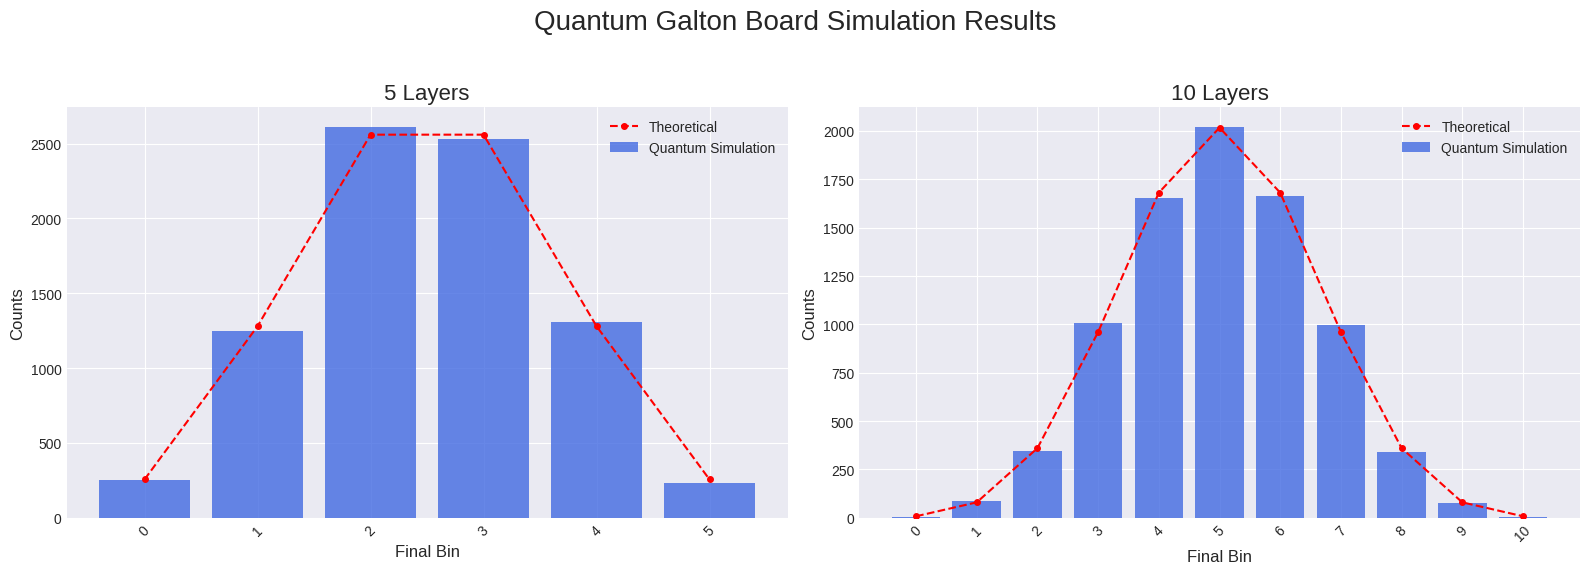


Simulations complete.


In [3]:

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from scipy.special import comb
#Task 2

def create_qgb_circuit(num_layers: int) -> QuantumCircuit:
    """
    Creates a generalized Quantum Galton Board circuit.
    """
    num_bins = num_layers + 1
    bin_qubits = QuantumRegister(num_bins, name='bin')
    control_qubit = QuantumRegister(1, name='control')
    classical_bits = ClassicalRegister(num_bins, name='c')
    qc = QuantumCircuit(bin_qubits, control_qubit, classical_bits)

    # 1. Initialize the state
    qc.x(bin_qubits[0])
    qc.barrier()

    # 2. Build the layers
    for i in range(num_layers):
        qc.reset(control_qubit[0])
        qc.h(control_qubit[0])
        for j in range(i, -1, -1):
            qc.cswap(control_qubit[0], bin_qubits[j], bin_qubits[j+1])
        qc.barrier()

    # 3. Measurement
    qc.measure(bin_qubits, classical_bits)
    return qc

def run_simulation(qc: QuantumCircuit, shots: int = 8192):
    """
    Simulates the given quantum circuit and returns the results.
    """
    simulator = AerSimulator()
    result = simulator.run(qc, shots=shots).result()
    counts = result.get_counts(qc)
    return counts

def process_counts(counts: dict, num_layers: int):
    """
    Processes the raw counts from the simulator into a simple list
    of final bin counts.
    """
    num_bins = num_layers + 1
    processed_counts = [0] * num_bins
    for bitstring, count in counts.items():
        clean_bitstring = bitstring.replace(" ", "")
        try:
            bin_index = clean_bitstring[::-1].index('1')
            if bin_index < num_bins:
                processed_counts[bin_index] += count
        except ValueError:
            pass
    return processed_counts


# --- MAIN EXECUTION ---
if __name__ == '__main__':
    # --- Configuration ---
    # Running for just 5 and 10 layers for faster execution.
    layers_to_test = [5, 10]
    SHOTS = 8192

    # Create a 1x2 subplot grid
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Quantum Galton Board Simulation Results', fontsize=20)

    # Loop through each number of layers to test
    for i, num_layers in enumerate(layers_to_test):
        print(f"--- Running simulation for {num_layers} layers ---")
        ax = axes[i]

        # 1. Create the circuit
        qgb_circuit = create_qgb_circuit(num_layers)

        # 2. Run the simulation
        raw_counts = run_simulation(qgb_circuit, shots=SHOTS)

        # 3. Process the results
        final_counts = process_counts(raw_counts, num_layers)

        # 4. Plot the results on the appropriate subplot
        bin_labels = [f'{j}' for j in range(num_layers + 1)]

        # Plot quantum simulation results
        ax.bar(bin_labels, final_counts, color='royalblue', alpha=0.8, label='Quantum Simulation')

        # Plot theoretical binomial distribution for comparison
        n = num_layers
        p = 0.5
        theoretical_dist = [comb(n, k) * (p**k) * ((1-p)**(n-k)) * SHOTS for k in range(n + 1)]
        ax.plot(bin_labels, theoretical_dist, color='red', marker='o', markersize=4, linestyle='--', label=f'Theoretical')

        ax.set_title(f'{num_layers} Layers', fontsize=16)
        ax.set_xlabel('Final Bin', fontsize=12)
        ax.set_ylabel('Counts', fontsize=12)

        # Rotate x-axis labels for better readability
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()

    print("\nSimulations complete.")


--- Running simulation for Exponential Distribution ---
--- Running simulation for Grover Quantum Walk ---


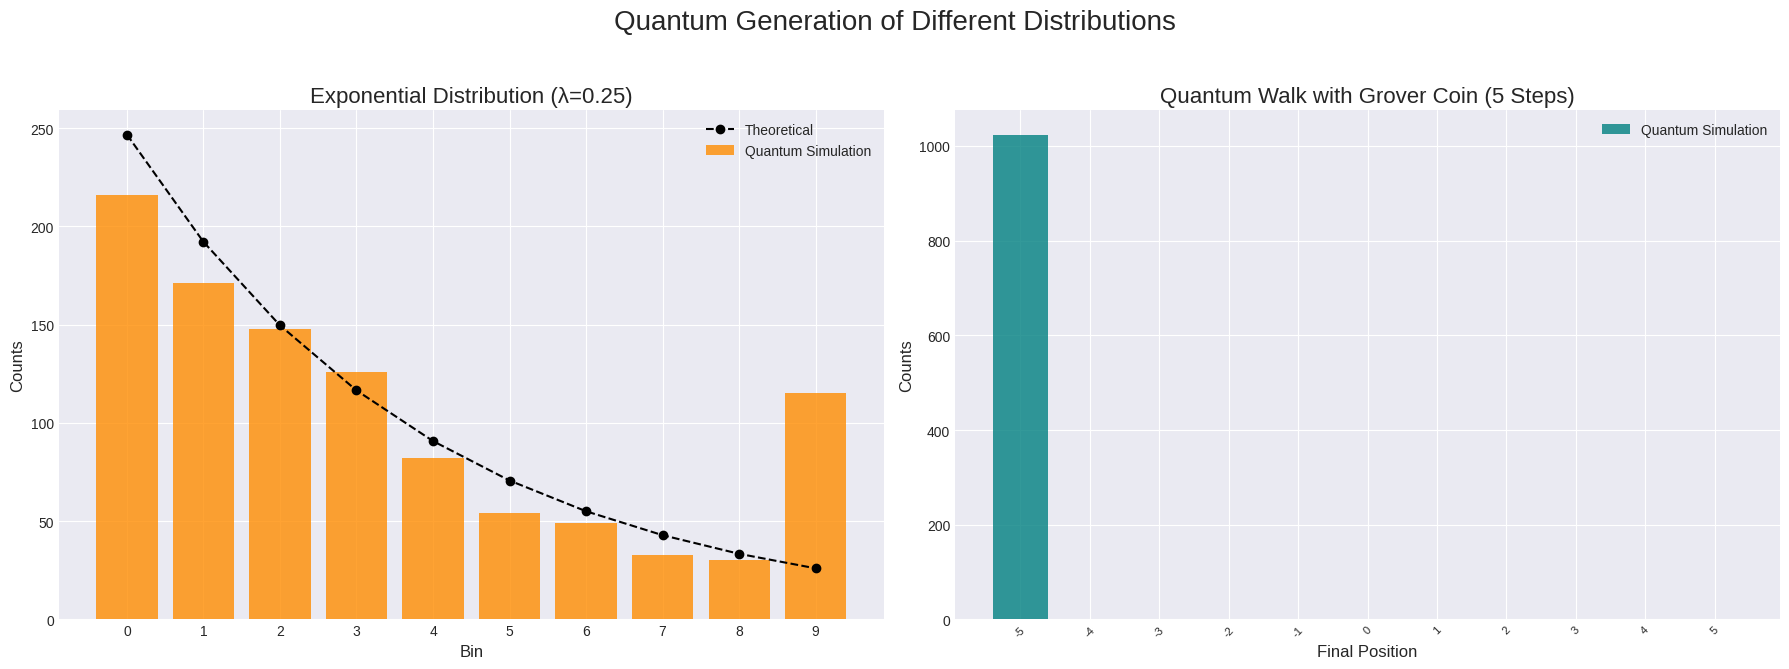

In [4]:
#
# Quantum Walks for Generating Different Target Distributions
#
# This script demonstrates how to modify the basic Quantum Galton Board
# (which is a Hadamard Quantum Walk) to generate other distributions.
# It provides implementations for:
# 1. An Exponential Distribution, by creating a biased random walk.
# 2. A Quantum Walk using Grover's operator as the "coin", which produces
#    a distinct two-peaked distribution.
#
# To install dependencies:
# !pip install qiskit qiskit-aer matplotlib numpy scipy
#

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from scipy.stats import expon

def create_exponential_dist_circuit(num_bins: int, decay_rate: float) -> QuantumCircuit:
    """
    Creates a circuit to generate an exponential distribution.

    This is a "biased" quantum walk. At each step, the probability of the
    walker moving to the next bin decreases. This is done by replacing the
    Hadamard gate with an Rx(theta) gate, where theta is adjusted at each step.

    Args:
        num_bins: The number of possible bins (i.e., the length of the walk).
        decay_rate: The lambda parameter for the exponential distribution.

    Returns:
        A Qiskit QuantumCircuit object.
    """
    position_qubits = QuantumRegister(num_bins, name='pos')
    # A single control qubit is recycled.
    control_qubit = QuantumRegister(1, name='control')
    classical_bits = ClassicalRegister(num_bins, name='c')
    qc = QuantumCircuit(position_qubits, control_qubit, classical_bits)

    # Start the walker at the first position.
    qc.x(position_qubits[0])
    qc.barrier()

    for i in range(num_bins - 1):
        # The probability of continuing the walk (moving right) at step i
        # should follow an exponential decay.
        # prob_continue = exp(-decay_rate * i)
        # The relationship between Rx(theta) and probability is P(|1>) = sin^2(theta/2).
        # We set P(|1>) to be the probability of stopping.
        prob_stop = 1 - np.exp(-decay_rate) # Constant probability to stop at each step

        # We need to be careful if prob_stop is outside [0, 1]
        prob_stop = max(0, min(1, prob_stop))

        theta = 2 * np.arcsin(np.sqrt(prob_stop))

        qc.reset(control_qubit)
        qc.ry(theta, control_qubit) # Use Ry for bias

        # If control is |0> (continue), swap the walker to the next position.
        # We use an x-gate to trigger the swap on |0> instead of |1>.
        qc.x(control_qubit)
        qc.cswap(control_qubit, position_qubits[i], position_qubits[i+1])
        qc.x(control_qubit) # Uncompute
        qc.barrier()

    qc.measure(position_qubits, classical_bits)
    return qc


def create_grover_walk_circuit(num_steps: int) -> QuantumCircuit:
    """
    Creates a circuit for a discrete-time quantum walk on a line
    using Grover's diffusion operator as the coin.

    Args:
        num_steps: The number of steps in the walk.

    Returns:
        A Qiskit QuantumCircuit object.
    """
    # Position space needs to cover -num_steps to +num_steps.
    # Total positions = 2 * num_steps + 1
    num_positions = 2 * num_steps + 1
    position_qubits = QuantumRegister(num_positions, name='pos')
    coin_qubit = QuantumRegister(1, name='coin')
    classical_bits = ClassicalRegister(num_positions, name='c')
    qc = QuantumCircuit(position_qubits, coin_qubit, classical_bits)

    # 1. Initialize walker at the center position
    center_index = num_steps
    qc.x(position_qubits[center_index])

    # 2. Initialize coin in superposition |+>
    qc.h(coin_qubit)
    qc.barrier()

    # 3. Perform the walk for num_steps
    for _ in range(num_steps):
        # --- Conditional Shift Operator ---
        # If coin is |0> (or |+>), move left (i -> i-1)
        # If coin is |1> (or |->), move right (i -> i+1)
        for i in range(num_positions):
            # Move right if coin is 1
            if i < num_positions - 1:
                qc.cswap(coin_qubit, position_qubits[i], position_qubits[i+1])

        for i in range(num_positions):
             # Move left if coin is 0. We simulate this by flipping the coin,
             # doing a right-shift, and flipping it back.
            if i > 0:
                qc.x(coin_qubit)
                qc.cswap(coin_qubit, position_qubits[i], position_qubits[i-1])
                qc.x(coin_qubit)
        qc.barrier()

        # --- Coin Operator (Grover's Diffusion Operator) ---
        # This is HZH = 2|0><0| - I, followed by a phase shift.
        # The full operator is 2|s><s| - I where |s> = H|0>
        qc.h(coin_qubit)
        qc.z(coin_qubit)
        qc.h(coin_qubit)
        # Global phase shift to make it a reflection about |s>
        qc.global_phase = np.pi
        qc.barrier()


    qc.measure(position_qubits, classical_bits)
    return qc


def run_simulation(qc: QuantumCircuit, shots: int = 1024):
    """Simulates the circuit."""
    simulator = AerSimulator()
    result = simulator.run(qc, shots=shots).result()
    return result.get_counts(qc)

def process_counts(counts: dict, num_bins: int):
    """Processes raw counts into a list of bin counts."""
    processed_counts = [0] * num_bins
    for bitstring, count in counts.items():
        # The bitstring may contain a space from the register separation
        clean_bitstring = bitstring.replace(" ", "")
        try:
            # Qiskit's bitstring order is qN...q0, so we reverse it
            bin_index = clean_bitstring[::-1].index('1')
            if bin_index < num_bins:
                processed_counts[bin_index] += count
        except ValueError:
            pass # Ignore bitstrings with no '1'
    return processed_counts


# --- MAIN EXECUTION ---
if __name__ == '__main__':
    # --- Configuration (Parameters reduced for faster execution) ---
    SHOTS = 1024

    # --- Setup for Plotting ---
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle('Quantum Generation of Different Distributions', fontsize=20)

    # --- 1. Exponential Distribution ---
    print("--- Running simulation for Exponential Distribution ---")
    ax_exp = axes[0]
    NUM_BINS_EXP = 10
    DECAY_RATE = 0.25 # Lambda

    exp_circuit = create_exponential_dist_circuit(NUM_BINS_EXP, DECAY_RATE)
    exp_counts = run_simulation(exp_circuit, SHOTS)
    exp_final_counts = process_counts(exp_counts, NUM_BINS_EXP)

    # Plotting
    bin_labels_exp = [f'{i}' for i in range(NUM_BINS_EXP)]
    ax_exp.bar(bin_labels_exp, exp_final_counts, color='darkorange', alpha=0.8, label='Quantum Simulation')

    # Theoretical curve
    x_theory = np.arange(NUM_BINS_EXP)
    y_theory_exp = expon.pdf(x_theory, scale=1/DECAY_RATE)
    # Scale to match simulation shots
    y_theory_exp = y_theory_exp / np.sum(y_theory_exp) * SHOTS
    ax_exp.plot(x_theory, y_theory_exp, color='black', marker='o', linestyle='--', label='Theoretical')

    ax_exp.set_title(f'Exponential Distribution (λ={DECAY_RATE})', fontsize=16)
    ax_exp.set_xlabel('Bin', fontsize=12)
    ax_exp.set_ylabel('Counts', fontsize=12)
    ax_exp.legend()

    # --- 2. Grover Quantum Walk ---
    print("--- Running simulation for Grover Quantum Walk ---")
    ax_grover = axes[1]
    NUM_STEPS_GROVER = 5
    NUM_POSITIONS_GROVER = 2 * NUM_STEPS_GROVER + 1

    grover_circuit = create_grover_walk_circuit(NUM_STEPS_GROVER)
    grover_counts = run_simulation(grover_circuit, SHOTS)
    grover_final_counts = process_counts(grover_counts, NUM_POSITIONS_GROVER)

    # Plotting
    bin_labels_grover = [f'{i - NUM_STEPS_GROVER}' for i in range(NUM_POSITIONS_GROVER)]
    ax_grover.bar(bin_labels_grover, grover_final_counts, color='teal', alpha=0.8, label='Quantum Simulation')
    ax_grover.set_title(f'Quantum Walk with Grover Coin ({NUM_STEPS_GROVER} Steps)', fontsize=16)
    ax_grover.set_xlabel('Final Position', fontsize=12)
    ax_grover.set_ylabel('Counts', fontsize=12)
    ax_grover.tick_params(axis='x', rotation=45, labelsize=8)
    ax_grover.legend()


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [12]:
!pip install qiskit qiskit-aer matplotlib numpy scipy qiskit-ibm-provider


In [18]:
#Task 4
# Optimized Quantum Walks for Noisy Simulation
#
# This script implements and evaluates an optimization strategy for running the
# exponential and Grover walk circuits on a noisy quantum computer simulator.
#
# The core challenge is that noise on real hardware degrades results. The
# primary optimization is replacing the high-level C-SWAP (Fredkin) gate
# with a more hardware-friendly decomposition to reduce the circuit's
# susceptibility to noise after transpilation.
#
# The script will:
# 1. Define both the original and optimized circuits for each distribution.
# 2. Run them on a realistic noise model from a fake IBM backend (FakeManila).
# 3. Plot the results to visually compare the performance.
# 4. Calculate the Hellinger distance to quantify the improvement in accuracy.
#
# To install dependencies:
# !pip install qiskit qiskit-aer matplotlib numpy scipy qiskit-ibm-provider
#

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
# Corrected import path for FakeManila
from qiskit.providers.fake_provider import FakeManila
from scipy.special import comb
from scipy.stats import expon

# --- OPTIMIZATION & ANALYSIS FUNCTIONS ---

def optimized_cswap(qc, control, target1, target2):
    """Applies a C-SWAP gate using a more hardware-friendly decomposition."""
    qc.ccx(control, target2, target1)
    qc.ccx(control, target1, target2)
    qc.ccx(control, target2, target1)

def hellinger_distance(p, q):
    """Calculates the Hellinger distance between two probability distributions."""
    p = np.asarray(p)
    q = np.asarray(q)
    p = p / np.sum(p) if np.sum(p) > 0 else p
    q = q / np.sum(q) if np.sum(q) > 0 else q
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / np.sqrt(2)

# --- CIRCUIT CREATION FUNCTIONS ---

def create_exponential_dist_circuit(num_bins: int, decay_rate: float, optimized: bool) -> QuantumCircuit:
    """Creates a circuit for an exponential distribution (standard or optimized)."""
    qc = QuantumCircuit(QuantumRegister(num_bins, name='pos'),
                        QuantumRegister(1, name='control'),
                        ClassicalRegister(num_bins, name='c'))
    pos_q, ctrl_q, c_bits = qc.qregs[0], qc.qregs[1], qc.cregs[0]

    qc.x(pos_q[0])
    qc.barrier()

    for i in range(num_bins - 1):
        prob_stop = 1 - np.exp(-decay_rate)
        theta = 2 * np.arcsin(np.sqrt(max(0, min(1, prob_stop))))
        qc.reset(ctrl_q[0])
        qc.ry(theta, ctrl_q[0])
        qc.x(ctrl_q[0])
        if optimized:
            optimized_cswap(qc, ctrl_q[0], pos_q[i], pos_q[i+1])
        else:
            qc.cswap(ctrl_q[0], pos_q[i], pos_q[i+1])
        qc.x(ctrl_q[0])
        qc.barrier()
    qc.measure(pos_q, c_bits)
    return qc

def create_grover_walk_circuit(num_steps: int, optimized: bool) -> QuantumCircuit:
    """Creates a circuit for a Grover walk (standard or optimized)."""
    num_positions = 2 * num_steps + 1
    qc = QuantumCircuit(QuantumRegister(num_positions, name='pos'),
                        QuantumRegister(1, name='coin'),
                        ClassicalRegister(num_positions, name='c'))
    pos_q, coin_q, c_bits = qc.qregs[0], qc.qregs[1], qc.cregs[0]

    qc.x(pos_q[num_steps])
    qc.h(coin_q[0])
    qc.barrier()

    for _ in range(num_steps):
        # Conditional Shift
        for i in range(num_positions):
            if i < num_positions - 1: # Move right
                if optimized:
                    optimized_cswap(qc, coin_q[0], pos_q[i], pos_q[i+1])
                else:
                    qc.cswap(qc, coin_q[0], pos_q[i], pos_q[i+1]) # Corrected: added qc argument
        qc.barrier()
        # Grover Coin Operator
        qc.h(coin_q[0])
        qc.z(coin_q[0])
        qc.h(coin_q[0])
        qc.barrier()


    qc.measure(pos_q, c_bits)
    return qc

def process_counts(counts: dict, num_bins: int):
    """Processes raw counts into a list of bin counts."""
    processed_counts = [0] * num_bins
    for bitstring, count in counts.items():
        clean_bitstring = bitstring.replace(" ", "")
        try:
            bin_index = clean_bitstring[::-1].index('1')
            if bin_index < num_bins:
                processed_counts[bin_index] += count
        except ValueError:
            pass
    return processed_counts

# --- MAIN EXECUTION ---
if __name__ == '__main__':
    # --- Configuration ---
    # Using small parameters because noise is very impactful
    SHOTS = 4096
    NUM_BINS_EXP = 5
    DECAY_RATE = 0.4
    NUM_STEPS_GROVER = 2

    # 1. Load a realistic noise model
    print("Loading noise model from FakeManila...")
    device_backend = FakeManila()
    noise_simulator = AerSimulator.from_backend(device_backend)

    # --- Setup for Plotting ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Optimized vs. Unoptimized Performance on Noisy Simulator', fontsize=20)

    # --- 2. Exponential Distribution Simulation ---
    print("\n--- Running Exponential Distribution Simulations ---")
    ax_exp = axes[0]

    # Run both versions
    unopt_exp_circ = create_exponential_dist_circuit(NUM_BINS_EXP, DECAY_RATE, optimized=False)
    opt_exp_circ = create_exponential_dist_circuit(NUM_BINS_EXP, DECAY_RATE, optimized=True)

    unopt_exp_results = noise_simulator.run(transpile(unopt_exp_circ, noise_simulator), shots=SHOTS).result()
    opt_exp_results = noise_simulator.run(transpile(opt_exp_circ, noise_simulator), shots=SHOTS).result()

    # Process and plot
    unopt_exp_counts = process_counts(unopt_exp_results.get_counts(), NUM_BINS_EXP)
    opt_exp_counts = process_counts(opt_exp_results.get_counts(), NUM_BINS_EXP)

    x_exp = np.arange(NUM_BINS_EXP)
    ax_exp.bar(x_exp - 0.2, unopt_exp_counts, 0.4, label='Unoptimized', color='indianred')
    ax_exp.bar(x_exp + 0.2, opt_exp_counts, 0.4, label='Optimized', color='cornflowerblue')

    # Theoretical curve
    y_theory_exp = expon.pdf(np.arange(NUM_BINS_EXP), scale=1/DECAY_RATE)
    y_theory_exp_prob = y_theory_exp / np.sum(y_theory_exp)
    ax_exp.plot(x_exp, y_theory_exp_prob * SHOTS, 'k--', marker='o', label='Theoretical Ideal')

    ax_exp.set_title(f'Exponential Distribution ({NUM_BINS_EXP} Bins)', fontsize=16)
    ax_exp.set_xlabel('Bin', fontsize=12)
    ax_exp.set_ylabel('Counts', fontsize=12)
    ax_exp.set_xticks(x_exp)
    ax_exp.legend()

    # --- 3. Grover Walk Simulation ---
    print("--- Running Grover Walk Simulations ---")
    ax_grover = axes[1]
    NUM_POSITIONS_GROVER = 2 * NUM_STEPS_GROVER + 1

    unopt_grover_circ = create_grover_walk_circuit(NUM_STEPS_GROVER, optimized=False)
    opt_grover_circ = create_grover_walk_circuit(NUM_STEPS_GROVER, optimized=True)

    unopt_grover_results = noise_simulator.run(transpile(unopt_grover_circ, noise_simulator), shots=SHOTS).result()
    opt_grover_results = noise_simulator.run(transpile(opt_grover_circ, noise_simulator), shots=SHOTS).result()

    unopt_grover_counts = process_counts(unopt_grover_results.get_counts(), NUM_POSITIONS_GROVER)
    opt_grover_counts = process_counts(opt_grover_results.get_counts(), NUM_POSITIONS_GROVER)

    x_grover = np.arange(NUM_POSITIONS_GROVER)
    ax_grover.bar(x_grover - 0.2, unopt_grover_counts, 0.4, label='Unoptimized', color='indianred')
    ax_grover.bar(x_grover + 0.2, opt_grover_counts, 0.4, label='Cornflowerblue', color='cornflowerblue')

    # Theoretical curve for Grover walk is harder to compute, so we run a noiseless sim
    noiseless_simulator = AerSimulator()
    ideal_grover_results = noiseless_simulator.run(transpile(opt_grover_circ, noiseless_simulator), shots=SHOTS).result()
    ideal_grover_counts = process_counts(ideal_grover_results.get_counts(), NUM_POSITIONS_GROVER)
    ideal_grover_prob = np.array(ideal_grover_counts) / SHOTS
    ax_grover.plot(x_grover, ideal_grover_counts, 'k--', marker='o', label='Theoretical Ideal')

    ax_grover.set_title(f'Grover Walk ({NUM_STEPS_GROVER} Steps)', fontsize=16)
    ax_grover.set_xlabel('Final Position', fontsize=12)
    ax_grover.set_xticks(x_grover)
    ax_grover.set_xticklabels([f'{i - NUM_STEPS_GROVER}' for i in range(NUM_POSITIONS_GROVER)])
    ax_grover.legend()

    # --- 4. Quantitative Analysis ---
    print("\n--- Hellinger Distance from Ideal Distribution ---")
    dist_unopt_exp = hellinger_distance(unopt_exp_counts, y_theory_exp_prob * SHOTS)
    dist_opt_exp = hellinger_distance(opt_exp_counts, y_theory_exp_prob * SHOTS)
    print(f"Exponential Dist | Unoptimized: {dist_unopt_exp:.4f}, Optimized: {dist_opt_exp:.4f}")

    dist_unopt_grover = hellinger_distance(unopt_grover_counts, ideal_grover_prob * SHOTS)
    dist_opt_grover = hellinger_distance(opt_grover_counts, ideal_grover_prob * SHOTS)
    print(f"Grover Walk      | Unoptimized: {dist_unopt_grover:.4f}, Optimized: {dist_opt_grover:.4f}")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

ImportError: cannot import name 'FakeManila' from 'qiskit.providers.fake_provider' (/usr/local/lib/python3.11/dist-packages/qiskit/providers/fake_provider/__init__.py)